In [1]:
%matplotlib inline

import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import tvm
from tvm import relay

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #Activamos cuda en el caso de que esté disponible

In [2]:
# parameters
RANDOM_SEED = 42 #Semilla para generar números aleatorios
LEARNING_RATE = 0.001 #Tasa de aprendizaje
BATCH_SIZE = 32 #Tamaño del batch
N_EPOCHS = 15 #Número de épocas (vueltas)

IMG_SIZE = 32 #Tamaño de la imagen
N_CLASSES = 10 #Número de clases

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad(): #Las siguientes ejecuciones no tienen el gradiente activado
        model.eval() #Modo de evaluación
        for X, y_true in data_loader: #se obtienen los datos

            X = X.to(device) #Se lleva el número a gpu
            y_true = y_true.to(device) #Se lleva el número correcto a gpu

            _, y_prob = model(X) #se obtiene el tensor de predicción de X aplicando el modelo
            _, predicted_labels = torch.max(y_prob, 1) #Se obtiene el mayor valor del tensor para obtener la predicción

            n += y_true.size(0) #Aumentamos el número de casos ejecutados
            correct_pred += (predicted_labels == y_true).sum() #Aumentamos el número de aciertos en el caso de que la predicción sea correcta

    return correct_pred.float() / n #Obtenemos la tasa de acierto



In [4]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn') #Se utiliza el estilo de dibujo y visualizzación 'Seaborn'

    train_losses = np.array(train_losses) #Transformamos los datos de train_losses en array
    valid_losses = np.array(valid_losses) #Transformamos los datos de valid_losses en array

    fig, ax = plt.subplots(figsize = (8, 4.5)) #Crea el gráfico con sus ejes, la figura y un tamaño de 8 y 4,5

    ax.plot(train_losses, color='blue', label='Training loss') #Configuración de dibujo de la pérdida de entrenamiento (azul)
    ax.plot(valid_losses, color='red', label='Validation loss') #Configuración de dibujo de la pérdida de validación (rojo)
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') #Dibuja la leyenda del gráfico (Pérdidas por época, pérdida y época)
    ax.legend() #Configura la leyenda
    fig.show() #Dibuja el grafico
    
    # change the plot style to default
    plt.style.use('default') #Se utiliza el estilo de dibujo y visualizzación por defecto

In [47]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train() #Entrenamos el modelo
    running_loss = 0 #Inicializamos la pérdida a 0
    
    for X, y_true in train_loader: #Obtenemos X(imágenes), e Y_true(etiquetas correctas) del dataset 

        optimizer.zero_grad() #Se inician los gradientes a 0
        
        X = X.to(device) #Se lleva X a GPU
        y_true = y_true.to(device) #Se lleva y_true a GPU
    
        # Forward pass
        y_hat, _ = model(X) #Aplicamos el modelo en X y obtenemos la predicción
        loss = criterion(y_hat, y_true) #Calculamos la pérdida comparando la predicción con el valor correcto
        running_loss += loss.item() * X.size(0) #Aumentamos el valor de la pérdida total sumando la pérdida actual con el tamaño de la imagen actual

        # Backward pass
        loss.backward() #Acumula el gradiente para el parámetro de pérdida
        optimizer.step() #Actualiza el parámetro en función del gradiente
        
    epoch_loss = running_loss / len(train_loader.dataset) #Calculamos la pérdida por época
    return model, optimizer, epoch_loss #Devolvemos el modelo, el gradiente y la pérdida por época

In [48]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval() #Evaluamos (validamos) el modelo
    running_loss = 0 #Inicializamos la pérdida a 0
    
    for X, y_true in valid_loader: #Obtenemos X(imágenes), e Y_true(etiquetas correctas) del dataset
    
        X = X.to(device) #Se lleva X a GPU
        y_true = y_true.to(device) #Se lleva y_true a GPU

        # Forward pass and record loss
        y_hat, _ = model(X) #Aplicamos el modelo en X y obtenemos la predicción
        loss = criterion(y_hat, y_true) #Calculamos la pérdida comparando la predicción con el valor correcto
        running_loss += loss.item() * X.size(0) #Aumentamos el valor de la pérdida total sumando la pérdida actual

    epoch_loss = running_loss / len(valid_loader.dataset) #Calculamos la pérdida por época
        
    return model, epoch_loss #Devolvemos el modelo y la pérdida por época

In [7]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10 #Inicializamos la mejor pérdida a un valor grande
    train_losses = [] #Creamos array de pérdidas de entrenamiento
    valid_losses = [] #Creamos array de pérdidas de validación
 
    # Train model
    for epoch in range(0, epochs): #Modelo de entrenamiento que recorre todas las épocas

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device) #Llamada a la función de entrenamiento
        train_losses.append(train_loss) #Añadimos al array de pérdidas de entrenamiento, la périda del entrenamiento de la época

        # validation
        with torch.no_grad(): #Las siguientes ejecuciones no tienen el gradiente activado
            model, valid_loss = validate(valid_loader, model, criterion, device) #Llamada a la función de validación
            valid_losses.append(valid_loss) #Añadimos al array de pérdidas de validaciones, la périda de validación de la época

        if epoch % print_every == (print_every - 1): #Condición para imprimir datos cada época
            
            train_acc = get_accuracy(model, train_loader, device=device) #Tasa de acierto de entrenamiento
            valid_acc = get_accuracy(model, valid_loader, device=device) #Tasa de acierto de validación
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}') #Mostramos datos de cada época

    plot_losses(train_losses, valid_losses) #Dibujamos las pérdidas
    
    return model, optimizer, (train_losses, valid_losses) #Devolvemos el modelo, optimizador(gradiente) y pérdidas

In [8]:
class LeNet5(nn.Module):

    def __init__(self, n_classes): #Inicializador de Lenet5
        super(LeNet5, self).__init__() #Iniciamos Lenet5
        
        self.feature_extractor = nn.Sequential( #Instrucciones secuenciales que recrean Lenet5         
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), #Capa1: 1 canal de entrada, 6 de salida, tamaño kernel 5, stride 1
            nn.Tanh(), #Aplica función Tanh
            nn.AvgPool2d(kernel_size=2), #Aplica una agrupación media 2D sobre una señal de entrada compuesta de varios planos de entrada
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), #Capa2: 6 canales de entrada, 16 de salida, tamaño kernel 5, stride 1
            nn.Tanh(),#Aplica función Tanh
            nn.AvgPool2d(kernel_size=2), #Aplica una agrupación media 2D sobre una señal de entrada compuesta de varios planos de entrada
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), #Capa3: 1 canales de entrada, 120 de salida, tamaño kernel 5, stride 1
            nn.Tanh()#Aplica función Tanh
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84), #Aplica una transformación linear a los datos de entrada. Datos de entrada: 120, datos de salida: 84
            nn.Tanh(), #Aplica función Tanh
            nn.Linear(in_features=84, out_features=n_classes), #Aplica una transformación linear a los datos de entrada. Datos de entrada: 84, datos de salida: n_classes
        )


    def forward(self, x): #Implementación de Lenet5
        x = self.feature_extractor(x) #Extrae las características de X y las guarda en X
        x = torch.flatten(x, 1) #Aplana un rango de atenuaciones en un tensor. Comienzo de dimensión: X, final de dimensión:1
        logits = self.classifier(x) #Clasificamos los valores de X
        probs = F.softmax(logits, dim=1) #Aplica la función softmax a logits con dimensión 1 para calcular las probabilidades
        return logits, probs #Devuelve logits y probabilidades

In [9]:
tvm.target.datatype.register("bfloat", 129)

In [10]:
tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func(
        {
            (32, 16): "FloatToCustom32",  # cast from float32 to myfloat32
        }
    ),
    "Cast",
    "llvm",
    "float",
    "bfloat",
)
#------------------------------------------------------------------------
tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Add"}),
    "Add",
    "llvm",
    "bfloat",
)
tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({(16, 32): "Custom32ToFloat"}),
    "Cast",
    "llvm",
    "bfloat",
    "float",
)
#------------------------------------------------------------------------
tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "FloatToCustom32"}),
    "FloatImm",
    "llvm",
    "bfloat",
)

tvm.target.datatype.register_op(
    tvm.target.datatype.lower_ite, "Call", "llvm", "bfloat", intrinsic_name="tir.if_then_else"
)

tvm.target.datatype.register_op(
    tvm.target.datatype.lower_call_pure_extern,
    "Call",
    "llvm",
    "bfloat",
    intrinsic_name="tir.call_pure_extern",
)

tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Mul"}),
    "Mul",
    "llvm",
    "bfloat",
)
tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Div"}),
    "Div",
    "llvm",
    "bfloat",
)

tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Sqrt"}),
    "Call",
    "llvm",
    "bfloat",
    intrinsic_name="tir.sqrt",
)

tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Sub"}),
    "Sub",
    "llvm",
    "bfloat",
)

tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Exp"}),
    "Call",
    "llvm",
    "bfloat",
    intrinsic_name="tir.exp",
)

tvm.target.datatype.register_op(
    tvm.target.datatype.create_lower_func({16: "Custom32Max"}),
    "Max",
    "llvm",
    "bfloat",
)

tvm.target.datatype.register_min_func(
    tvm.target.datatype.create_min_lower_func({16: "MinCustom32"}, "bfloat"),
    "bfloat",
)

In [11]:
def convert_ndarray(dst_dtype, array):
    """Converts an NDArray into the specified datatype"""
    str_dtype= str(array.dtype)
    if str_dtype == "torch.float32":
        str_dtype = "float32"
    x = relay.var("x", shape=array.shape, dtype=str_dtype)
    cast = relay.Function([x], x.astype(dst_dtype))
    with tvm.transform.PassContext(config={"tir.disable_vectorize": True}):
        return relay.create_executor("graph").evaluate(cast)(array)

In [12]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()]) #Variable que tendrá las especificaciones de los tensores de datos

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True) #Descargamos y creamos el dataset de entrenamiento

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms) #Descargamos y creamos el dataset de validación

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)  #Definimos el dataset de entrenamiento

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)  #Descargamos y creamos el dataset de validación

In [22]:
X_train = []
Y_train = []
X_valid = []
Y_valid = []
for X, y_true in train_loader: 
    X = convert_ndarray("custom[bfloat]16", X)
    X_train.append(X)
    Y_train.append(y_true)
for X, y_true in valid_loader: 
    X = convert_ndarray("custom[bfloat]16", X)
    X_valid.append(X)
    Y_valid.append(y_true)    

In [35]:
list_train = []
list_train.append(X_train)
list_train.append(Y_train)
len(list_train[0])

1875

In [13]:
x_bfloat = relay.cast(x, dtype="custom[bfloat]16")
y_bfloat = relay.cast(y, dtype="custom[bfloat]16")
z_bfloat = x_bfloat + y_bfloat
z = relay.cast(z_bfloat, dtype="float32")
program = relay.Function([x, y], z)
module = tvm.IRModule.from_expr(program)
module = relay.transform.InferType()(module)

NameError: name 'x' is not defined

In [14]:
from tvm.relay.frontend.change_datatype import ChangeDatatype

src_dtype = "float32"
dst_dtype = "custom[bfloat]16"

module = relay.transform.InferType()(module)

# Currently, custom datatypes only work if you run simplify_inference beforehand
module = tvm.relay.transform.SimplifyInference()(module)

# Run type inference before changing datatype
module = tvm.relay.transform.InferType()(module)

# Change datatype from float to myfloat and re-infer types
cdtype = ChangeDatatype(src_dtype, dst_dtype)
expr = cdtype.visit(module["main"])
module = tvm.relay.transform.InferType()(module)

# We also convert the parameters:
params = {k: convert_ndarray(dst_dtype, v) for k, v in params.items()}

# We also need to convert our input:
input = convert_ndarray(dst_dtype, input)

# Finally, we can try to run the converted model:
try:
    # Vectorization is not implemented with custom datatypes.
    with tvm.transform.PassContext(config={"tir.disable_vectorize": True}):
        result_bfloat = ex.evaluate(expr)(input, **params)
except tvm.TVMError as e:
    print(str(e).split("\n")[-1])

NameError: name 'module' is not defined

In [39]:
ROW_IMG = 10
N_ROWS = 5

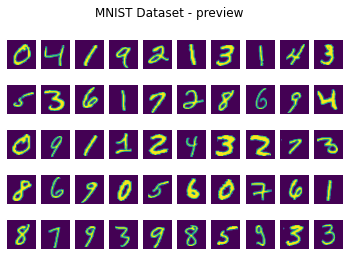

In [40]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

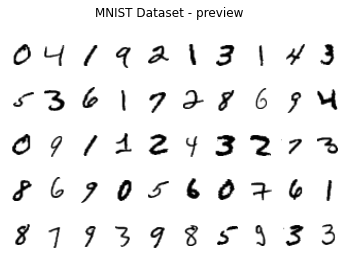

In [41]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [42]:
torch.manual_seed(RANDOM_SEED) #Insertamos la semilla manual aleatoria para comenzar

model = LeNet5(N_CLASSES).to(DEVICE) #Guardamos en model Lenet5 con 10 clases y ejecución en GPU
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #Aplicamos la función de optimización Adam a los parámetros del modelo y con la tasa de aprendizaje
criterion = nn.CrossEntropyLoss() #Cuando no existe un dataset de entrenamoento equilibrado es util. Se encarga de minimizar la pérdida

In [46]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

TypeError: array must be an array_like data,type <class 'torch.Tensor'> is not supported

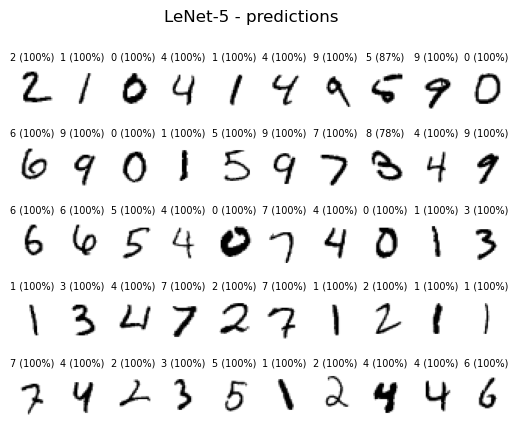

In [20]:
ROW_IMG = 10 #Imágenes por fila
N_ROWS = 5 #Nº de filas

fig = plt.figure() #Dibujo de figura
for index in range(1, ROW_IMG * N_ROWS + 1): #Recorremos la matriz predefinida
    plt.subplot(N_ROWS, ROW_IMG, index) #Reservamos el hueco de la imagen correspondiente
    plt.axis('off') #desactivamos ejes
    plt.imshow(valid_dataset.data[index], cmap='gray_r') #Dibujamos la imagen correspondiente en escala de grises
    
    with torch.no_grad(): #Las siguientes ejecuciones no tienen el gradiente activado
        model.eval() #evaluamos el modelo
        _, probs = model(valid_dataset[index][0].cuda().unsqueeze(0)) #Modified, sacamos las probabilidades de acierto
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)' #Imprimimos la predicción  las probabilidades de acierto
    
    plt.title(title, fontsize=7) #Colocamos la predicción como título de la imagen
fig.suptitle('LeNet-5 - predictions'); #Colocamos el título de toda la ejecución

In [ ]:
# Now, we can run our program without errors.
with tvm.transform.PassContext(config={"tir.disable_vectorize": True}):
    x = relay.create_executor("graph", mod=module)
    compiled = ex.evaluate(program)
    z_output_bfloat = compiled(x_input, y_input)
print("z: {}".format(z_output_bfloat))

In [13]:
def get_mobilenet():
    dshape = (1, 3, 224, 224)
    from mxnet.gluon.model_zoo.vision import get_model

    block = get_model("mobilenet0.25", pretrained=True)
    shape_dict = {"data": dshape}
    return relay.frontend.from_mxnet(block, shape_dict)


def get_cat_image():
    from tvm.contrib.download import download_testdata
    from PIL import Image

    url = "https://gist.githubusercontent.com/zhreshold/bcda4716699ac97ea44f791c24310193/raw/fa7ef0e9c9a5daea686d6473a62aacd1a5885849/cat.png"
    dst = "cat.png"
    real_dst = download_testdata(url, dst, module="data")
    img = Image.open(real_dst).resize((224, 224))
    # CoreML's standard model image format is BGR
    img_bgr = np.array(img)[:, :, ::-1]
    img = np.transpose(img_bgr, (2, 0, 1))[np.newaxis, :]
    return np.asarray(img, dtype="float32")


module, params = get_mobilenet()

In [16]:
ex = tvm.relay.create_executor("graph", mod=module)
input = get_cat_image()
result = ex.evaluate()(input, **params).asnumpy()
# print first 10 elements
print(result.flatten()[:10])

File /home/rodrigo/.tvm_test_data/data/cat.png exists, skip.


Cannot find config for target=llvm -keys=cpu -link-params=0, workload=('dense_pack.x86', ('TENSOR', (1, 256), 'float32'), ('TENSOR', (1000, 256), 'float32'), None, 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu -link-params=0, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 256, 7, 7), 'float32'), ('TENSOR', (256, 256, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu -link-params=0, workload=('depthwise_conv2d_NCHWc.x86', ('TENSOR', (1, 256, 7, 7), 'float32'), ('TENSOR', (256, 1, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu -link-params=0, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 128, 7, 7), 

[ -7.5350165   2.0368009 -12.706646   -5.63786   -12.684058    4.0723605
   2.618876    3.4049501  -9.867913  -24.53311  ]


Now, we would like to change the model to use myfloat internally. To do so, we need to convert the network. To do this, we first define a function which will help us convert tensors:



Now, to actually convert the entire network, we have written `a pass in Relay <https://github.com/gussmith23/tvm/blob/ea174c01c54a2529e19ca71e125f5884e728da6e/python/tvm/relay/frontend/change_datatype.py#L21>`_ which simply converts all nodes within the model to use the new datatype.



When we attempt to run the model, we get a familiar error telling us that more funcions need to be registerd for myfloat.

Because this is a neural network, many more operations are required.
Here, we register all the needed functions:



In [20]:
# Vectorization is not implemented with custom datatypes.
with tvm.transform.PassContext(config={"tir.disable_vectorize": True}):
    result_bfloat = ex.evaluate(expr)(input, **params)
    result_bfloat = convert_ndarray(src_dtype, result_bfloat).asnumpy()
    # print first 10 elements
    print(result_bfloat.flatten()[:10])

# Again, note that the output using 32-bit myfloat exactly the same as 32-bit floats,
# because myfloat is exactly a float!
np.testing.assert_array_equal(result, result_bfloat)

[-3.1244152e-12  6.1829492e-41  1.9622862e-10  1.6982336e-41
  5.5014274e-12  1.6054677e-41 -5.8357532e+28  8.5821123e-41
  1.2083474e-23  9.1154465e-42]


AssertionError: 
Arrays are not equal

x and y nan location mismatch:
 x: array([[-7.535017e+00,  2.036801e+00, -1.270665e+01, -5.637860e+00,
        -1.268406e+01,  4.072361e+00,  2.618876e+00,  3.404950e+00,
        -9.867913e+00, -2.453311e+01, -2.894642e+01, -2.097970e+01,...
 y: array([[-3.124415e-12,  6.182949e-41,  1.962286e-10,  1.698234e-41,
         5.501427e-12,  1.605468e-41, -5.835753e+28,  8.582112e-41,
         1.208347e-23,  9.115447e-42,  1.874705e-29,  5.647233e-42,...

## Por hacer

### Importar librerias

https://posithub.org/

https://posithub.org/docs/PositTutorial_Part1.html